In [1]:
# torch imports
import torch
from torch import nn
from torch import optim
from torch.utils.data import Subset, Dataset, DataLoader, random_split

# torchvision imports
import torchvision
from torchvision import utils
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import functional as TF

from torchsummary import summary
from sklearn.model_selection import ShuffleSplit

import os
import copy
import yaml
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# create ./weights directory
if not os.path.exists('./weights'):
    os.mkdir('./weights')

# load hyperparameters dict
with open('hyperparameters.yml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [3]:
data_path = './data'
labels_path = './data/Training400/Fovea_location.xlsx'

labels_df = pd.read_excel(labels_path)
labels_df.describe()

,Unnamed: 0,ID,Fovea_X,Fovea_Y
count,398.000000,398.000000,398.000000,398.000000
mean,198.500000,199.500000,980.980770,957.508209
std,115.036951,115.036951,224.571692,192.908868
min,0.000000,1.000000,0.000000,0.000000
25%,99.250000,100.250000,775.621490,775.421191
50%,198.500000,199.500000,1048.533245,1035.870026
75%,297.750000,298.750000,1118.590335,1082.806373
max,397.000000,398.000000,1995.272727,1374.115464


In [4]:
labels_df = labels_df.replace(0, None)
labels_df.dropna()
labels_df[labels_df['Fovea_X'] == 0]

,Unnamed: 0,ID,imgName,Fovea_X,Fovea_Y


In [5]:
print(labels_df.head())
print(labels_df.tail())

   Unnamed: 0  ID    imgName      Fovea_X      Fovea_Y
0           0   1  A0001.jpg  1182.264278  1022.018842
1           1   2  A0002.jpg   967.754046  1016.946655
2           2   3  A0003.jpg  1220.206714   989.944033
3           3   4  A0004.jpg  1141.140888  1000.594955
4           4   5  A0005.jpg  1127.371832  1071.109440
     Unnamed: 0   ID    imgName     Fovea_X     Fovea_Y
393         393  394  N0307.jpg  823.024991  690.210211
394         394  395  N0308.jpg  647.598978  795.653188
395         395  396  N0309.jpg  624.571803  755.694880
396         396  397  N0310.jpg  687.523044  830.449187
397         397  398  N0311.jpg  746.107631  759.623062


In [6]:
labels_df[labels_df['imgName'].str.startswith('A')]

,Unnamed: 0,ID,imgName,Fovea_X,Fovea_Y
0,0,1,A0001.jpg,1182.264278,1022.018842
1,1,2,A0002.jpg,967.754046,1016.946655
2,2,3,A0003.jpg,1220.206714,989.944033
3,3,4,A0004.jpg,1141.140888,1000.594955
4,4,5,A0005.jpg,1127.371832,1071.109440
...,...,...,...,...,...
82,82,83,A0083.jpg,1181.719984,1058.496430
83,83,84,A0084.jpg,1034.745615,1073.474319
84,84,85,A0085.jpg,1099.317130,932.050025
85,85,86,A0086.jpg,974.981440,1008.517440


In [7]:
labels_df[labels_df['imgName'].str.startswith('N')]

,Unnamed: 0,ID,imgName,Fovea_X,Fovea_Y
87,87,88,N0001.jpg,1279.354269,1183.022499
88,88,89,N0002.jpg,1306.301802,1076.883738
89,89,90,N0003.jpg,1288.503773,1056.753381
90,90,91,N0004.jpg,1425.187031,970.644242
91,91,92,N0005.jpg,1002.039775,1064.412086
...,...,...,...,...,...
393,393,394,N0307.jpg,823.024991,690.210211
394,394,395,N0308.jpg,647.598978,795.653188
395,395,396,N0309.jpg,624.571803,755.694880
396,396,397,N0310.jpg,687.523044,830.449187


Image Size: (2124, 2056)
Image Size: (2124, 2056)
Image Size: (2124, 2056)
Image Size: (2124, 2056)
Image Size: (1444, 1444)
Image Size: (1444, 1444)
Image Size: (1444, 1444)
Image Size: (1444, 1444)


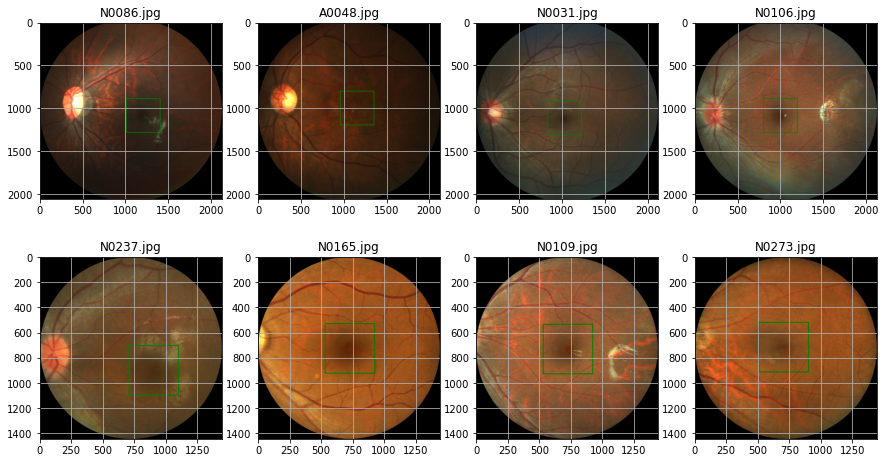

In [8]:
def load(labels_df, idx):
    img_name = labels_df['imgName']
    if img_name[idx][0] == 'A':
        label = 'AMD'
    else:
        label = 'Non-AMD'
    img_path = os.path.join(data_path, "Training400", label, img_name[idx])
    img = Image.open(img_path)
    x_coord=labels_df["Fovea_X"][idx]
    y_coord=labels_df["Fovea_Y"][idx]
    return img, (x_coord, y_coord)

def show(img, coord, wh=(400, 400), width=8):
    x_coord, y_coord = coord
    draw = ImageDraw.Draw(img)
    draw.rectangle(((x_coord-wh[1]/2, y_coord-wh[1]/2), (x_coord+wh[0]/2, y_coord+wh[0]/2)),outline="green",width=width)
    plt.imshow(np.asarray(img))
    plt.grid(None)

plt.rcParams['figure.figsize'] = (15, 8)
img_names = labels_df['imgName']
rand_idx = np.random.choice(labels_df.index, 8)

for i, idx in enumerate(rand_idx):
    img, label = load(labels_df, idx)
    print(f'Image Size: {img.size}')
    plt.subplot(2, 4, i+1)
    show(img,label)
    plt.title(img_names[idx])

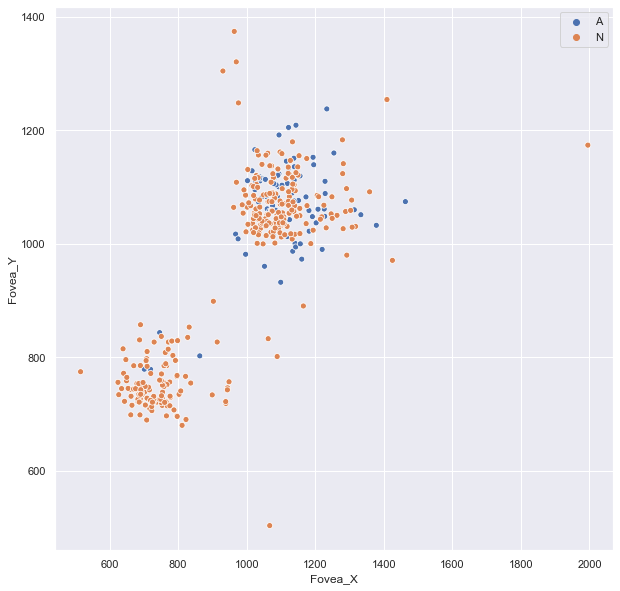

In [9]:
sns.set(rc={'figure.figsize': (10, 10)})

ARMD = [img_name[0] for img_name in img_names]
sns.scatterplot(labels_df['Fovea_X'], labels_df['Fovea_Y'], hue=ARMD)

In [10]:
def resize_fovea_loc(image: Image, fov_loc, target=(256, 256)):
    """
    standardizes image size, and scales fovea location

    :param image: image of retina
    :param fov_loc: location of fovea
    :param target: target size of image
    :return: new image and fovea location
    """
    w_img, h_img = image.size
    w_target, h_target = target
    x_fov, y_fov = fov_loc

    image = TF.resize(image, target)
    fov_loc = x_fov / w_img * w_target, y_fov / h_img * h_target
    return image, fov_loc

def rand_flip(image, fov_loc, p=0.5):
    """
    randomly flips image

    :param image: image to be flipped
    :param fov_loc: fovea location
    :param p: probability of flip
    :return: flipped image and fovea loc
    """
    rand_x = np.random.random(1)
    rand_y = np.random.random(1)

    w_img, h_img = image.size
    x_fov, y_fov = fov_loc

    if rand_x < p:
        image = TF.hflip(image)
        x_fov = w_img - x_fov

    if rand_y < p:
        image = TF.vflip(image)
        y_fov = h_img - y_fov

    return image, (x_fov, y_fov)



def rand_translate(image, fov_loc, threshold=(30, 30)):
    """
    randomly translates image

    :param image: image to be tranlated
    :param fov_loc: fovea location
    :param threshold: translation threshold - (horizontal, vertical)
    :return: translated image and fov loc
    """
    rand_x = np.random.rand(1)
    rand_y = np.random.rand(1)

    coeff_x = 1 if rand_x - 0.5 < 0 else -1
    coeff_y = 1 if rand_y - 0.5 < 0 else -1

    x_fov, y_fov = fov_loc

    translate_x = int(np.random.rand() * threshold[0]) * coeff_x
    translate_y = int(np.random.rand() * threshold[1]) * coeff_y
    image = TF.affine(image, translate=(translate_x, translate_y), shear=0, angle=0, scale=1)

    x_fov += translate_x
    y_fov += translate_y

    return image, (x_fov, y_fov)

def rand_bcg(image, fov_loc, p):
    """
    randomly adjusts brightness, contrast, and gamma

    :param image: image to be adjusted
    :param fov_loc: fovea location
    :param p: probability of adjustment
    :return: adjusted image and fov loc
    """
    brightness = np.random.uniform(.75, 1.25)
    contrast = np.random.uniform(0.8, 1.2)
    gamma = np.random.uniform(0.9, 1.1)

    if np.random.random() < p:
        image = TF.adjust_brightness(image, brightness)
    if np.random.random() < p:
        image = TF.adjust_contrast(image, contrast)
    if np.random.random() < p:
        image = TF.adjust_gamma(image, gamma)

    return image, fov_loc

def transform(image, fov_loc, target=(256, 256), p_flip=0.5, threshold=(30, 30), p_bcg=.5):
    """
    randomly transform image

    :param image: image to be transformed
    :param fov_loc: fovea location
    :param target: target image size
    :param p_flip: flip probability
    :param threshold: translate threshold
    :param p_bcg: brightness/contrast/gamma probability
    :return: translated image and fovea location
    """
    image, fov_loc = resize_fovea_loc(image, fov_loc, target)
    # image, fov_loc = rand_flip(image, fov_loc, p_flip)
    # image, fov_loc = rand_translate(image, fov_loc, threshold)
    # image, fov_loc = rand_bcg(image, fov_loc, p_bcg)

    image = TF.to_tensor(image)

    return image, fov_loc

Label: (135.1995833816913, 141.00456889575221)
Label: (124.64406626271699, 126.54475497129089)
Label: (126.29582882599051, 124.46671679154291)
Label: (129.18896893345294, 127.9605912408976)
Label: (129.20394188939807, 129.59921573728903)
Label: (154.19712470448815, 147.3024123421871)
Label: (125.09515839360482, 138.9220458685049)
Label: (157.44503832675917, 134.08669106644544)


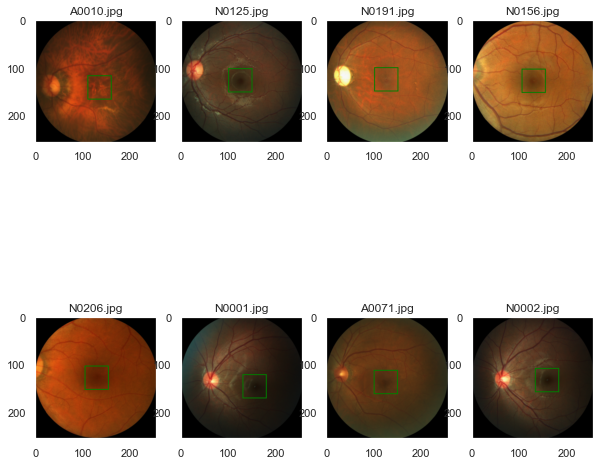

In [11]:
rand_idx = np.random.choice(labels_df.index, 8)

for i, idx in enumerate(rand_idx):
    img, label = load(labels_df, idx)
    img, label = transform(img, label)
    print(f'Label: {label}')
    plt.subplot(2, 4, i+1)
    show(TF.to_pil_image(img),label, wh=(50, 50), width=2)
    plt.title(img_names[idx])

In [12]:
class ARMDDataset(Dataset):
    def __init__(self, path, transform):
        labels_path = os.path.join(path, 'Training400', 'Fovea_location.xlsx')
        labels_df = pd.read_excel(labels_path)
        self.targets = labels_df[['Fovea_X', 'Fovea_Y']].values

        self.img_names = labels_df['imgName']
        self.ids = labels_df.index

        self.img_path = [0] * len(self.ids)
        for id in self.ids:
            if self.img_names[id][0] == 'A':
                pf = 'AMD'
            else:
                pf = 'Non-AMD'

            self.img_path[id-1] = os.path.join(path, 'Training400', pf, self.img_names[id])

        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        image = Image.open(self.img_path[idx])
        target = self.targets[idx]
        image, target = self.transform(image, target)

        return image, target

In [13]:
armd_dataset = ARMDDataset(data_path, transform)
ds_len = len(armd_dataset)
train_ds, val_ds = random_split(armd_dataset, [int(ds_len*.8), int(ds_len*.2) + 1])

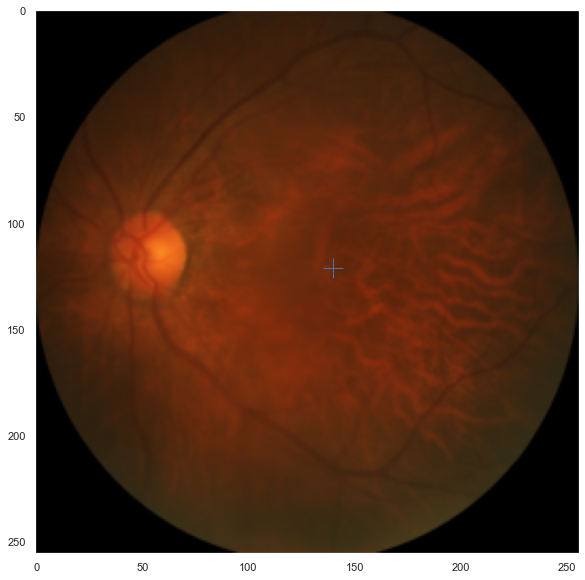

In [14]:
for idx, (image, label) in enumerate(train_ds):
    plt.clf()
    plt.grid(None)
    plt.imshow(image.numpy().transpose((1, 2, 0)))
    plt.plot(label[0], label[1], 'b+', markersize=20)
    if idx == 10:
        break